In [19]:
%%jinja markdown
Shape Technical Report

Shape Technical Report

In [27]:
%%jinja markdown
# Introduction

The development of predictive models for the maintenance of FPSO vessel equipment represents a pivotal advancement 
in the maritime and oil & gas industries, promising to revolutionize how these sectors approach maintenance management 
and operational efficiency. By leveraging historical data and advanced analytics, predictive models enable stakeholders 
to anticipate equipment failures before they occur, facilitating timely maintenance actions that can significantly 
reduce downtime and associated costs. This proactive approach not only enhances the reliability and safety of FPSO 
operations but also optimizes the lifecycle of critical equipment, ensuring that maintenance resources are allocated 
more effectively. In an industry where operational interruptions can lead to substantial financial losses and environmental 
risks, the ability to predict and mitigate potential failures through advanced modeling techniques is invaluable, driving 
improvements in operational resilience, cost-efficiency, and environmental stewardship.

## Objectives

The primary goal of this study is to conduct a comprehensive analysis of failures in 
FPSO vessels to derive actionable insights that will inform the optimal timing of maintenance interventions. 

To achieve this overarching goal, we have identified the following specific objectives:

1. **Assess Data Quality:** Examine the database to evaluate the integrity and quality of the data on FPSO vessel failures.
2. **Quantify Equipment Failures:** Calculate the frequency of equipment failures to understand their prevalence and impact.
3. **Analyze Failure Correlations:** Investigate the relationship between preset conditions and the occurrences of failures, identifying any significant patterns.
4. **Determine Parameter Influence:** Analyze how each parameter contributes to equipment failures, highlighting critical factors.
5. **Develop a Predictive Model:** Construct a model capable of predicting equipment failures based on analyzed variables, enhancing preemptive maintenance strategies.
6. **Evaluate Variable Significance:** Assess the importance of each variable within the predictive model to understand their impact on failure prediction accuracy.



# Methodology

# Introduction

The development of predictive models for the maintenance of FPSO vessel equipment represents a pivotal advancement 
in the maritime and oil & gas industries, promising to revolutionize how these sectors approach maintenance management 
and operational efficiency. By leveraging historical data and advanced analytics, predictive models enable stakeholders 
to anticipate equipment failures before they occur, facilitating timely maintenance actions that can significantly 
reduce downtime and associated costs. This proactive approach not only enhances the reliability and safety of FPSO 
operations but also optimizes the lifecycle of critical equipment, ensuring that maintenance resources are allocated 
more effectively. In an industry where operational interruptions can lead to substantial financial losses and environmental 
risks, the ability to predict and mitigate potential failures through advanced modeling techniques is invaluable, driving 
improvements in operational resilience, cost-efficiency, and environmental stewardship.

## Objectives

The primary goal of this study is to conduct a comprehensive analysis of failures in 
FPSO vessels to derive actionable insights that will inform the optimal timing of maintenance interventions. 

To achieve this overarching goal, we have identified the following specific objectives:

1. **Assess Data Quality:** Examine the database to evaluate the integrity and quality of the data on FPSO vessel failures.
2. **Quantify Equipment Failures:** Calculate the frequency of equipment failures to understand their prevalence and impact.
3. **Analyze Failure Correlations:** Investigate the relationship between preset conditions and the occurrences of failures, identifying any significant patterns.
4. **Determine Parameter Influence:** Analyze how each parameter contributes to equipment failures, highlighting critical factors.
5. **Develop a Predictive Model:** Construct a model capable of predicting equipment failures based on analyzed variables, enhancing preemptive maintenance strategies.
6. **Evaluate Variable Significance:** Assess the importance of each variable within the predictive model to understand their impact on failure prediction accuracy.



# Methodology

In [1]:
%load_ext pretty_jupyter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import chi2_contingency
from collections import Counter
from utils import *

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import shap

In [2]:
filename = "./O_G_Equipment_Data.xlsx"
data = pd.read_excel(filename)

In [3]:
%%jinja markdown
# Exploratory analysis

# Exploratory analysis

In [4]:
data.head()

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail
0,1,3,6,44.235186,47.657254,46.441769,64.820327,66.454520,44.483250,False
1,2,2,4,60.807234,63.172076,62.005951,80.714431,81.246405,60.228715,False
2,3,2,1,79.027536,83.032190,82.642110,98.254386,98.785196,80.993479,False
3,4,2,3,79.716242,100.508634,122.362321,121.363429,118.652538,80.315567,False
4,5,2,5,39.989054,51.764833,42.514302,61.037910,50.716469,64.245166,False


In [5]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Cycle        800 non-null    int64  
 1   Preset_1     800 non-null    int64  
 2   Preset_2     800 non-null    int64  
 3   Temperature  800 non-null    float64
 4   Pressure     800 non-null    float64
 5   VibrationX   800 non-null    float64
 6   VibrationY   800 non-null    float64
 7   VibrationZ   800 non-null    float64
 8   Frequency    800 non-null    float64
 9   Fail         800 non-null    bool   
dtypes: bool(1), float64(6), int64(3)
memory usage: 57.2 KB
None


## How many times the equipment has failed?

The equipment has failed 66 times
The failure rate is 8.25%


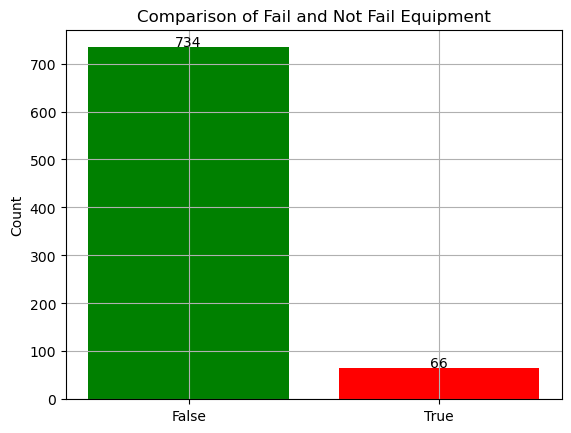

In [6]:
print(f"The equipment has failed {data['Fail'].value_counts().iloc[1]} times")
print(f"The failure rate is {data['Fail'].value_counts().iloc[1]/len(data)*100:.2f}%")
fails_conts = data['Fail'].value_counts()

labels = ['False', 'True']
counts = [fails_conts[False], fails_conts[True]]

fig, ax = plt.subplots()
ax.bar(labels, counts, color=['green', 'red'])

ax.set_ylabel('Count')
ax.set_title('Comparison of Fail and Not Fail Equipment')

for i in range(len(counts)):
    ax.text(i, counts[i] + 1, str(counts[i]), ha='center')
ax.grid()

plt.savefig('fail_not_fail.png', dpi=300 , bbox_inches='tight')


## Categorize failures by Presets

In [15]:
fails_per_preset_1 = data.groupby(['Preset_1', 'Fail']).size().unstack().sort_values(by=True, ascending=False)
fails_per_preset_2 = data.groupby(['Preset_2', 'Fail']).size().unstack().sort_values(by=True, ascending=False)

In [16]:
%%jmd
<details>
<summary>Table 1: Fails per Preset 1</summary>

{{ fails_per_preset_1.head().to_html()  }}
</details>

<details>
<summary>Table 2: Fails per Preset 2</summary>

{{ fails_per_preset_2.head().to_html() }}

</details>

<details>
<summary>Table 1: Fails per Preset 1</summary>

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Fail</th>
      <th>False</th>
      <th>True</th>
    </tr>
    <tr>
      <th>Preset_1</th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>1</th>
      <td>237</td>
      <td>27</td>
    </tr>
    <tr>
      <th>2</th>
      <td>260</td>
      <td>21</td>
    </tr>
    <tr>
      <th>3</th>
      <td>237</td>
      <td>18</td>
    </tr>
  </tbody>
</table>
</details>

<details>
<summary>Table 2: Fails per Preset 2</summary>

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Fail</th>
      <th>False</th>
      <th>True</th>
    </tr>
    <tr>
      <th>Preset_2</th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>5</th>
      <td>88</td>
      <td>12</td>
    </tr>
    <tr>
      <th>1</th>
      <td>84</td>
      <td>11</td>
    </tr>
    <tr>
      <th>2</th>
      <td>92</td>
      <td>9</td>
    </tr>
    <tr>
      <th>6</th>
      <td>92</td>
      <td>9</td>
    </tr>
    <tr>
      <th>7</th>
      <td>100</td>
      <td>9</td>
    </tr>
  </tbody>
</table>

</details>

In [49]:
%%jinja markdown

Tables 1 and 2 present the number of Fails for the preset$_1$ (left), and preset$_2$ (right). The configuration $1$ in preset$_1$ was the one with more failures; 
and the configuration $5$ was the one with more failures in preset$_2$.



Tables 1 and 2 present the number of Fails for the preset$_1$ (left), and preset$_2$ (right). The configuration $1$ in preset$_1$ was the one with more failures; 
and the configuration $5$ was the one with more failures in preset$_2$.

In [13]:
combination = data.groupby(['Preset_1','Preset_2', 'Fail']).size().unstack(fill_value=0)
combination['Percentage_fail'] = combination[True] / (combination[True] + combination[False]) * 100
combination['cumulative'] = combination[True].cumsum()
combination.reset_index(inplace=True)
combination.reset_index(inplace=True)

In [ ]:
%%jinja markdown


plots = sns.lmplot(x='index', y='cumulative', data=combination, fit_reg=True, legend=True, scatter_kws={'color': 'black'}, line_kws={'color': 'red'})
plots.set(title='Cumulative Failures')
plots.set(xlabel='Presset Combination', ylabel='Cumulative Failures')
plt.grid()
plt.savefig('cumulative_failures.png', dpi=300, bbox_inches='tight')

In [ ]:
%%jinja markdown

Here we want to evaluate how the combination of presets affecsts the equipment failures. 

In [14]:
combination_sorted =combination.sort_values(by=True, ascending=False)
combination_sorted

Fail,index,Preset_1,Preset_2,False,True,Percentage_fail,cumulative
1,1,1,2,33,5,13.157895,9
4,4,1,5,26,5,16.129032,18
0,0,1,1,30,4,11.764706,4
20,20,3,5,25,4,13.793103,59
6,6,1,7,34,4,10.526316,25
8,8,2,1,26,4,13.333333,31
15,15,2,8,33,4,10.810811,48
22,22,3,7,31,3,8.823529,65
21,21,3,6,27,3,10.000000,62
16,16,3,1,28,3,9.677419,51


Let's see now if the failues counts, has same relation with the cycles. The data was combined acoording to the pressets, and If there was or not a failure. The table in this first moment has the same order as the cyles running. The point here is to see if there is any point in time were we can see a tendency of growth or reduction in the cummulative events.

The figure layout has changed to tight


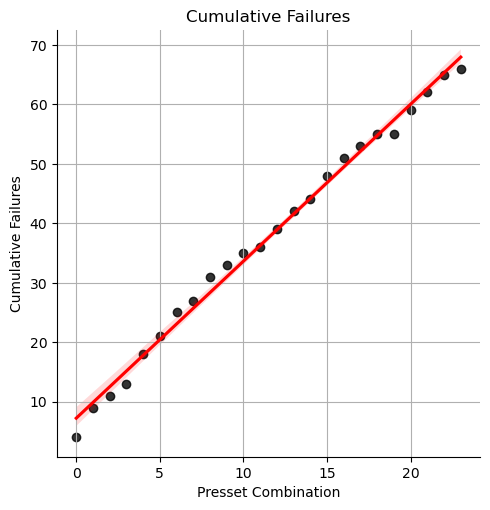

By looking the picture we just can see that the Failues happens during all the period, and the cumulative sum of failues increases over time. The cummulative curve is pratically linear. Although the curve is well lienarly fitted, not showing clear relation bewteen the presets and the failures, we can observe that around the combination 20, 11, 4,and 23, there is a little drop relatively to the curve. This could indicate that those presets could be countrinuing to a reduction in the cummulative sum. In other words, those combinations can have lower counts of failures.

We can see by looking the table that the combination of presets 3 and 4, had no failures. Also, the percentages of failues for 3-8 and 2-4 were the lowest. 

## Distribution of values

One way to evaluate the contribution of each variable in equipment failure is the distribution of its intensity. The Figure below show the distribution for each of the variables.

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating i

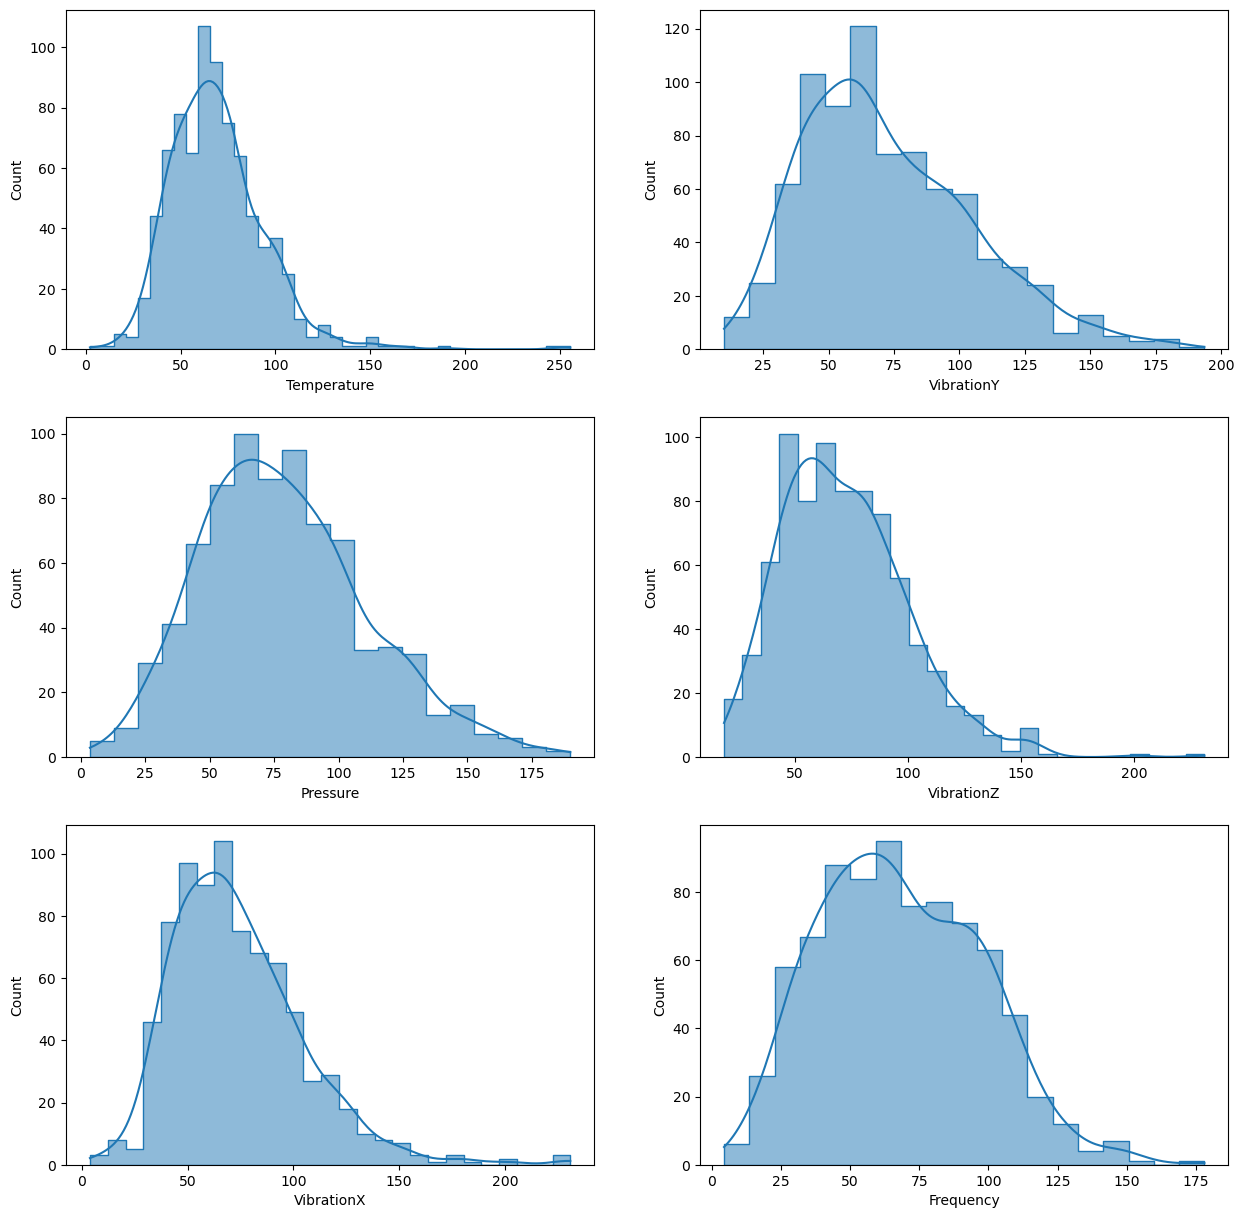

In [16]:
parameters = ['Temperature', 'Pressure','VibrationX', 'VibrationY', 'VibrationZ', 'Frequency']
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
axs = ax.T.flatten()
for axx in range(len(axs)):
    g = sns.histplot(data, x=parameters[axx], kde=True, element='step', legend=True, ax=axs[axx], common_norm=False)
    leg = g.axes.get_legend()
    axs[axx].set_xlabel(parameters[axx])
    axs[axx].set_ylabel('Count')
    new_title = 'Fail'
plt.savefig('histograms.png', dpi=300, bbox_inches='tight')

The Figure show the distribution of variables measurementes. All the sensors, expect the VibrationX, present a shape more like a bimodal distribution. It can be realated to a subgroup of values. Splitting the data in Failure and not Failure can give us a better understanding.

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_c

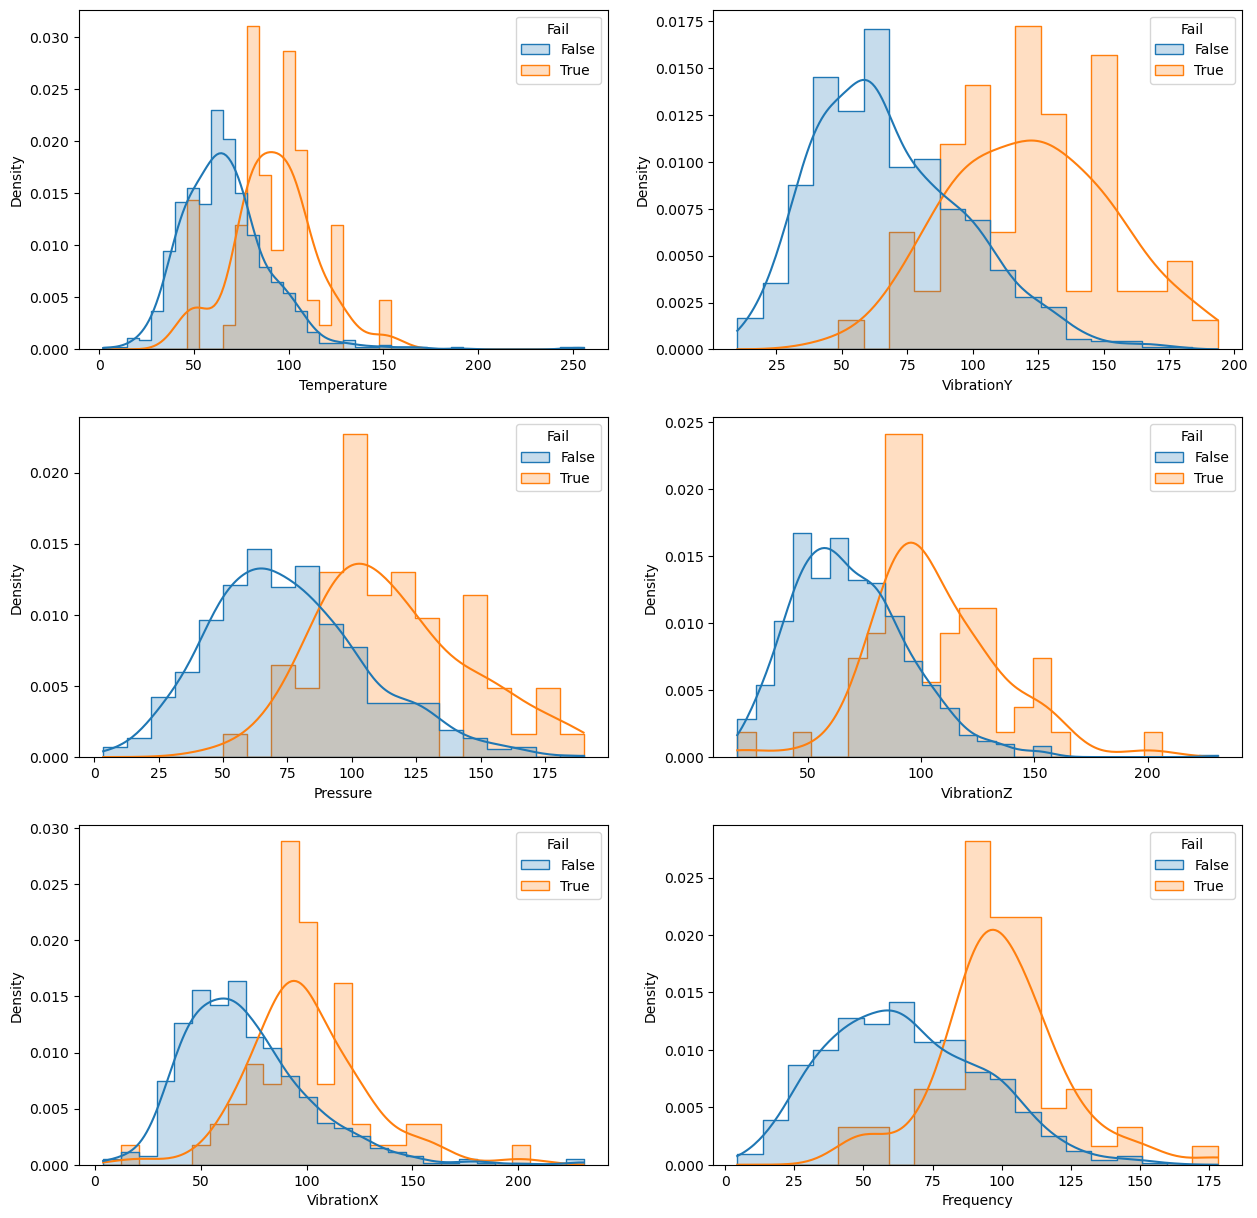

In [17]:
fig, ax = plt.subplots(3, 2, figsize=(15, 15))

axs = ax.T.flatten()

for axx in range(len(axs)):
    g = sns.histplot(data, x=parameters[axx], hue='Fail', kde=True, element='step', legend=True,stat='density', ax=axs[axx], common_norm=False)
    leg = g.axes.get_legend()
    axs[axx].set_xlabel(parameters[axx])
    axs[axx].set_ylabel('Density')
    new_title = 'Fail'
    leg.set_title(new_title)
    new_labels = ['False', 'True']
    for t, l in zip(leg.texts, new_labels):
        t.set_text(l)

plt.savefig('histograms_separated.png', dpi=300, bbox_inches='tight')

The distributions in the Figure above shows a clear separation in the Failures and not Failure measurements. We can see that the measurements have higher values when the failures happens. The VibrationZ, VibrationY, and Pressure were the ones that also have a tail with larger values. 

### Resampling the data

In [18]:
newDF = oversamplig_dataframe(data, 'Fail', method='ADASYN')

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


## Modeling prediciton

In [19]:
X = newDF.drop(columns=['Cycle','Preset_1', 'Preset_2', 'Fail'])
y = newDF.drop(columns=['Cycle', 'Preset_1', 'Preset_2', 'Temperature', 'Pressure', 'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency'])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.20, random_state=0)

In [21]:
ss_train = StandardScaler()
X_train = ss_train.fit_transform(X_train)

ss_test = StandardScaler()
X_test = ss_test.fit_transform(X_test)

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `

In [22]:
model = LogisticRegression()

model.fit(X_train, y_train)
predictions = model.predict(X_test)

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [23]:
cm = confusion_matrix(y_test, predictions)

TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


In [24]:
print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

True Positive(TP)  =  137
False Positive(FP) =  12
True Negative(TN)  =  147
False Negative(FN) =  0


In [25]:
accuracy =  (TP + TN) / (TP + FP + TN + FN)

print('Accuracy of the binary classifier = {:0.3f}'.format(accuracy))

Accuracy of the binary classifier = 0.959


### Variable importance (Explainability)

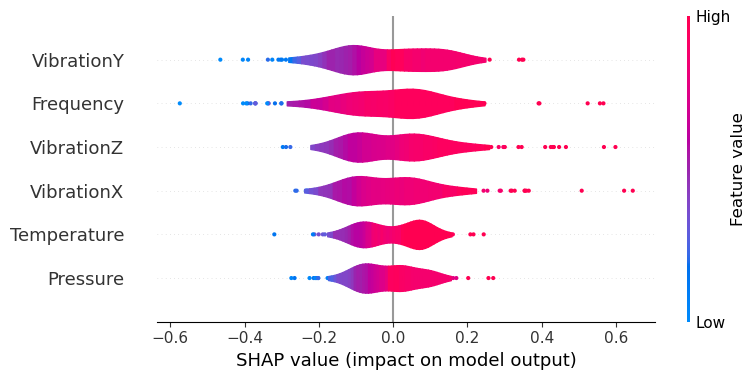

In [26]:
X_test_df = pd.DataFrame(X_test, columns=X.columns)
explainer = shap.Explainer(model.predict, X_test)
shap_values = explainer(X_test_df)
shap.summary_plot(shap_values, plot_type='violin', show=False)
plt.savefig('shap_summary_plot.png', dpi=300, bbox_inches='tight')

In [27]:
models = {}

# Logistic Regression
models['Logistic Regression'] = LogisticRegression()
# Support Vector Machines
models['Support Vector Machines'] = LinearSVC()
# Decision Trees
models['Decision Trees'] = DecisionTreeClassifier()
# Random Forest
models['Random Forest'] = RandomForestClassifier()
# Naive Bayes
models['Naive Bayes'] = GaussianNB()
# K-Nearest Neighbors
models['K-Nearest Neighbor'] = KNeighborsClassifier()

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy, precision, recall = {}, {}, {}

for key in models.keys():
    
    # Fit the classifier
    models[key].fit(X_train, y_train)
    
    # Make predictions
    predictions = models[key].predict(X_test)
    
    # Calculate metrics
    accuracy[key] = accuracy_score(predictions, y_test)
    precision[key] = precision_score(predictions, y_test)
    recall[key] = recall_score(predictions, y_test)

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future

In [29]:
import pandas as pd

df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall'])
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()
df_model

,Accuracy,Precision,Recall
Logistic Regression,0.959459,1.000000,0.919463
Support Vector Machines,0.959459,1.000000,0.919463
Decision Trees,0.925676,0.956204,0.891156
Random Forest,0.976351,1.000000,0.951389
Naive Bayes,0.922297,0.992701,0.860759
K-Nearest Neighbor,0.956081,1.000000,0.913333


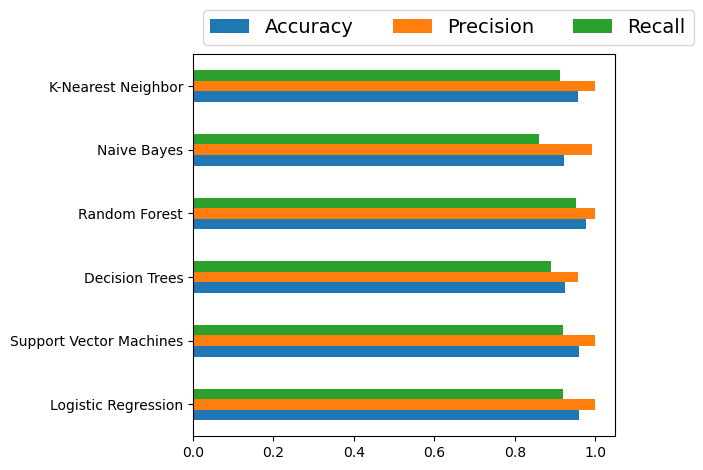

In [30]:
ax = df_model.plot.barh()
ax.legend(
    ncol=len(models.keys()), 
    bbox_to_anchor=(0, 1), 
    loc='lower left', 
    prop={'size': 14}
)
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')

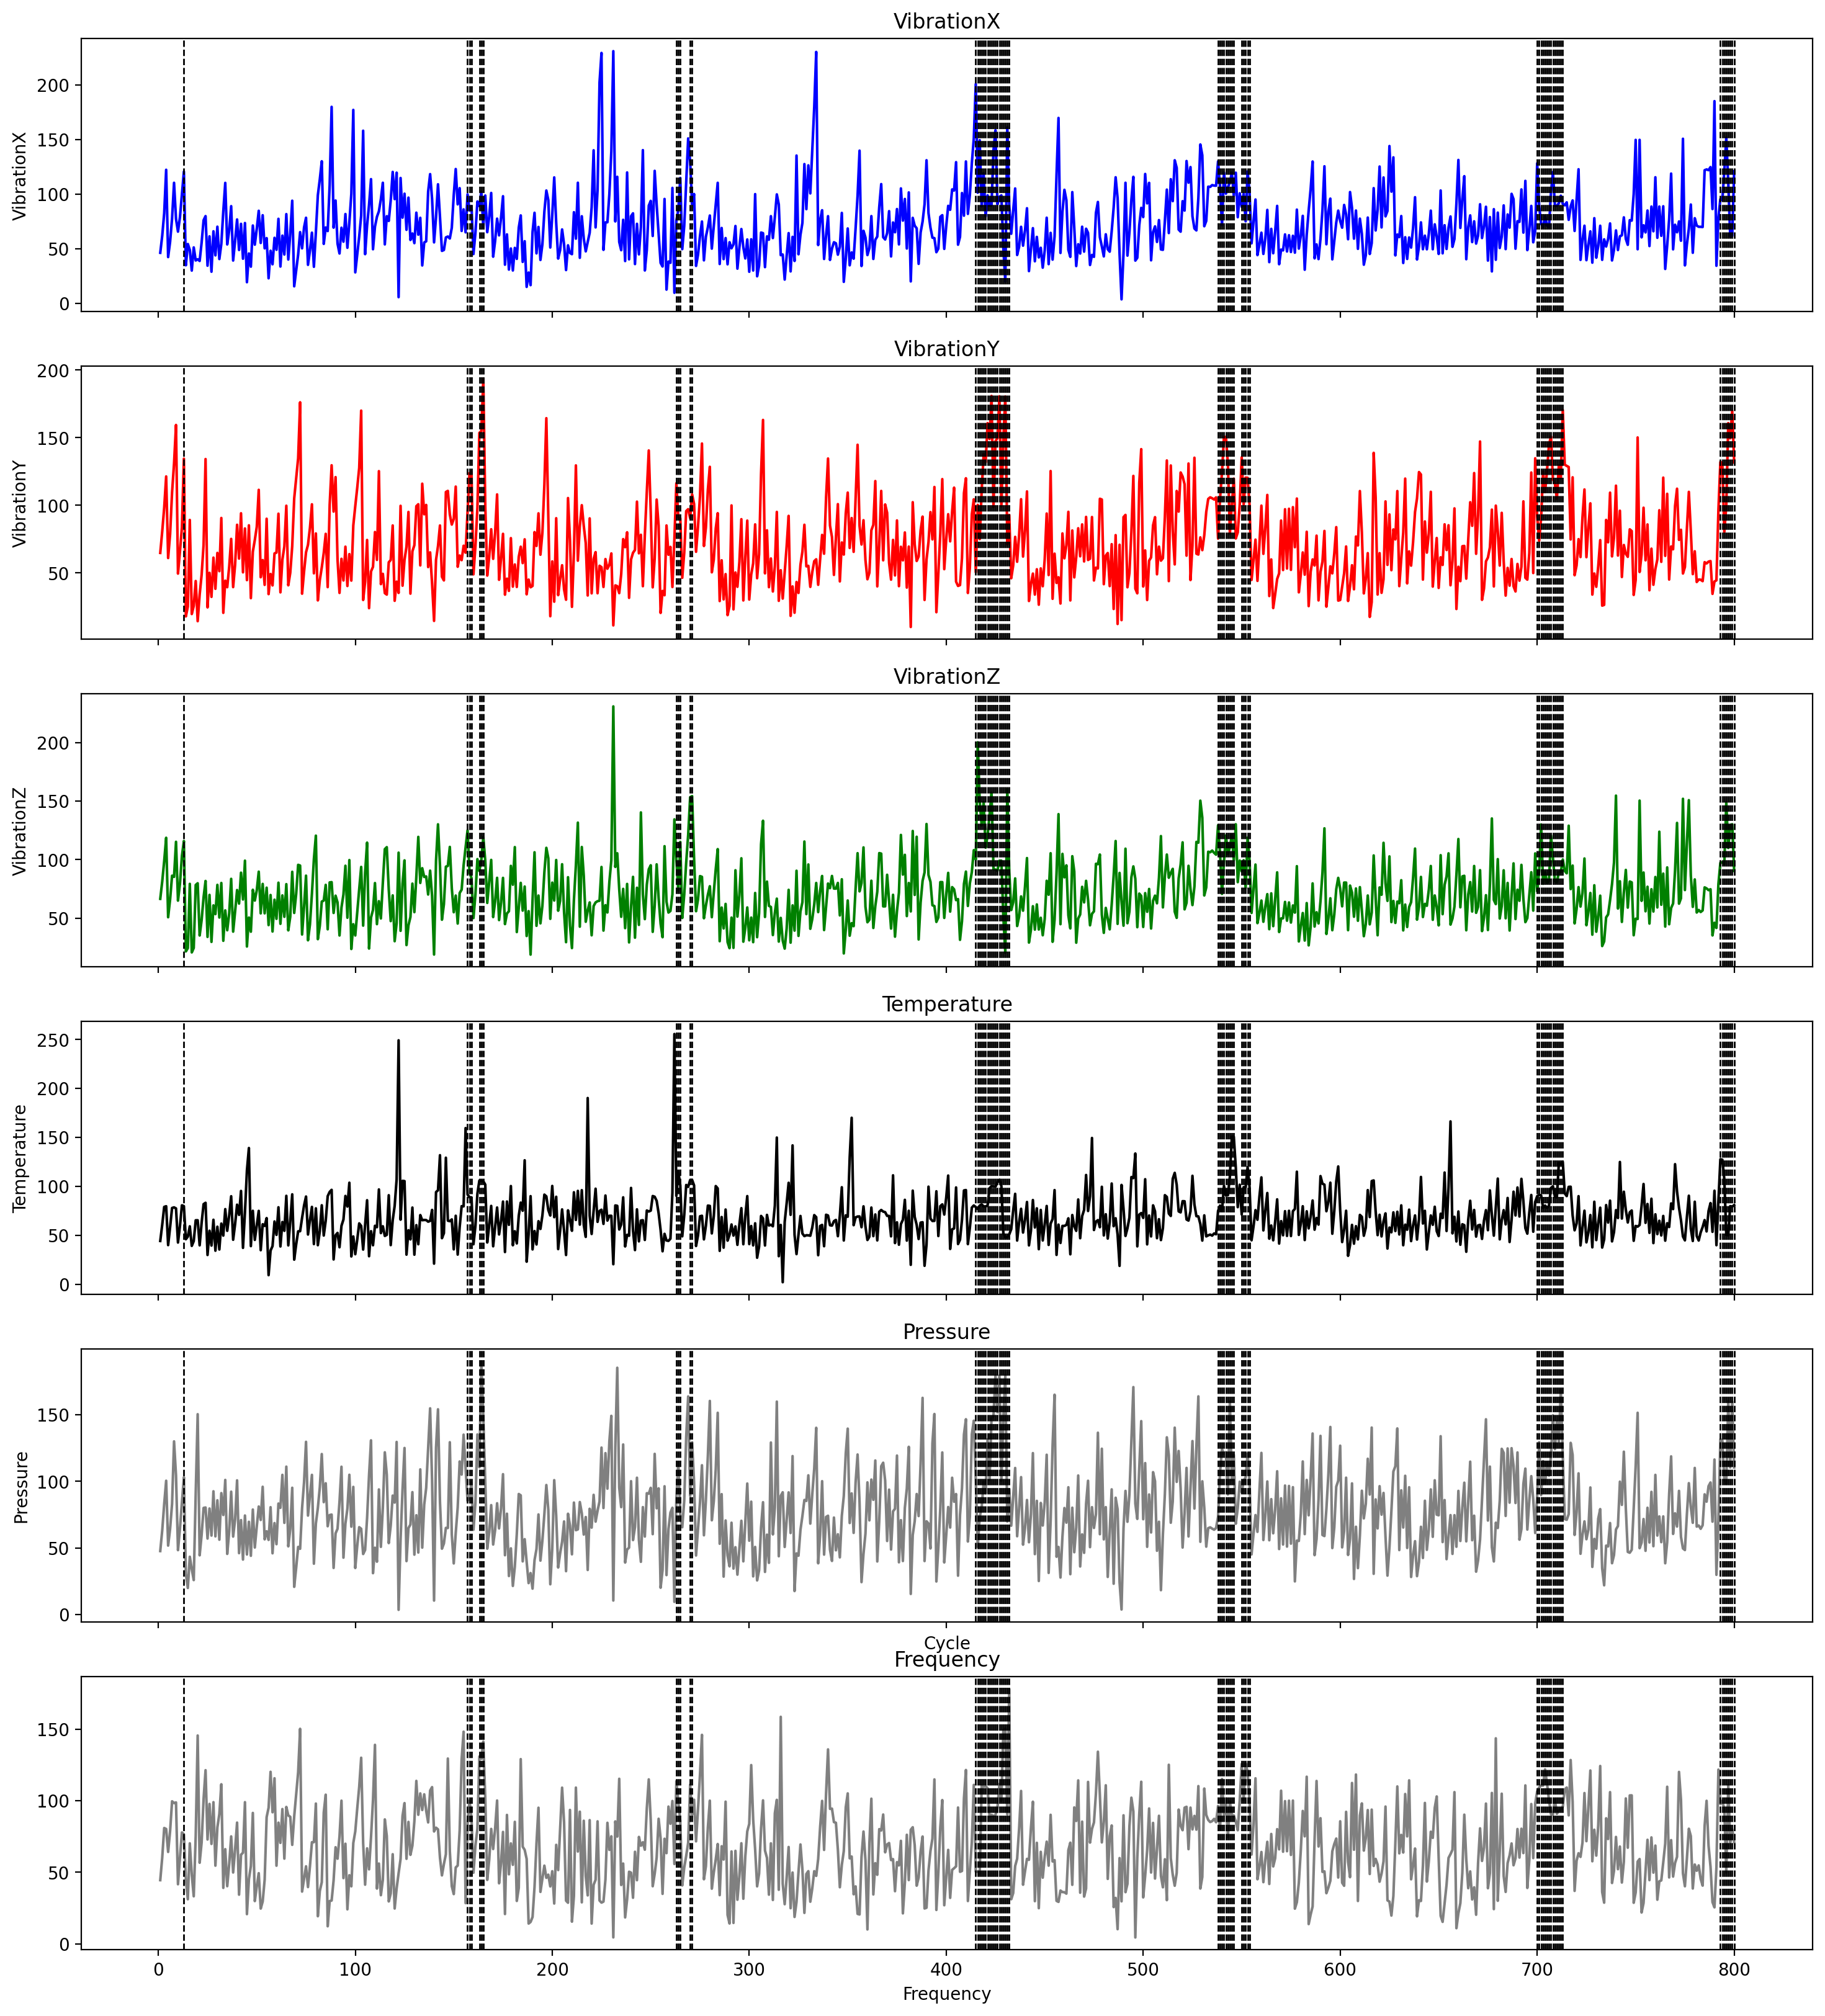

In [31]:

falhas = data[data['Fail'] == True]['Cycle']
fig, axs = plt.subplots(6, 1, figsize=(18, 20), sharex=True, dpi=200)
axs[0].plot(data['Cycle'], data['VibrationX'], label='VibrationX', color='blue')
axs[1].plot(data['Cycle'], data['VibrationY'], label='VibrationY', color='red')
axs[2].plot(data['Cycle'], data['VibrationZ'], label='VibrationZ', color='green')
axs[3].plot(data['Cycle'], data['Temperature'], label='VibrationX', color='black')
axs[4].plot(data['Cycle'], data['Pressure'], label='VibrationX', color='gray')
axs[5].plot(data['Cycle'], data['Frequency'], label='Frequency', color='gray')


for ax in axs:
    for ciclo in falhas:
        ax.axvline(x=ciclo, color='k', linestyle='--', linewidth=1)

axs[0].set_ylabel('VibrationX')
axs[1].set_ylabel('VibrationY')
axs[2].set_ylabel('VibrationZ')
axs[3].set_ylabel('Temperature')
axs[4].set_ylabel('Pressure')
axs[4].set_xlabel('Cycle')
axs[5].set_xlabel('Frequency')

axs[0].set_title('VibrationX')
axs[1].set_title('VibrationY')
axs[2].set_title('VibrationZ')
axs[3].set_title('Temperature')
axs[4].set_title('Pressure')
axs[5].set_title('Frequency')


plt.savefig('Vibration_Analysis.png', dpi=200, bbox_inches='tight')


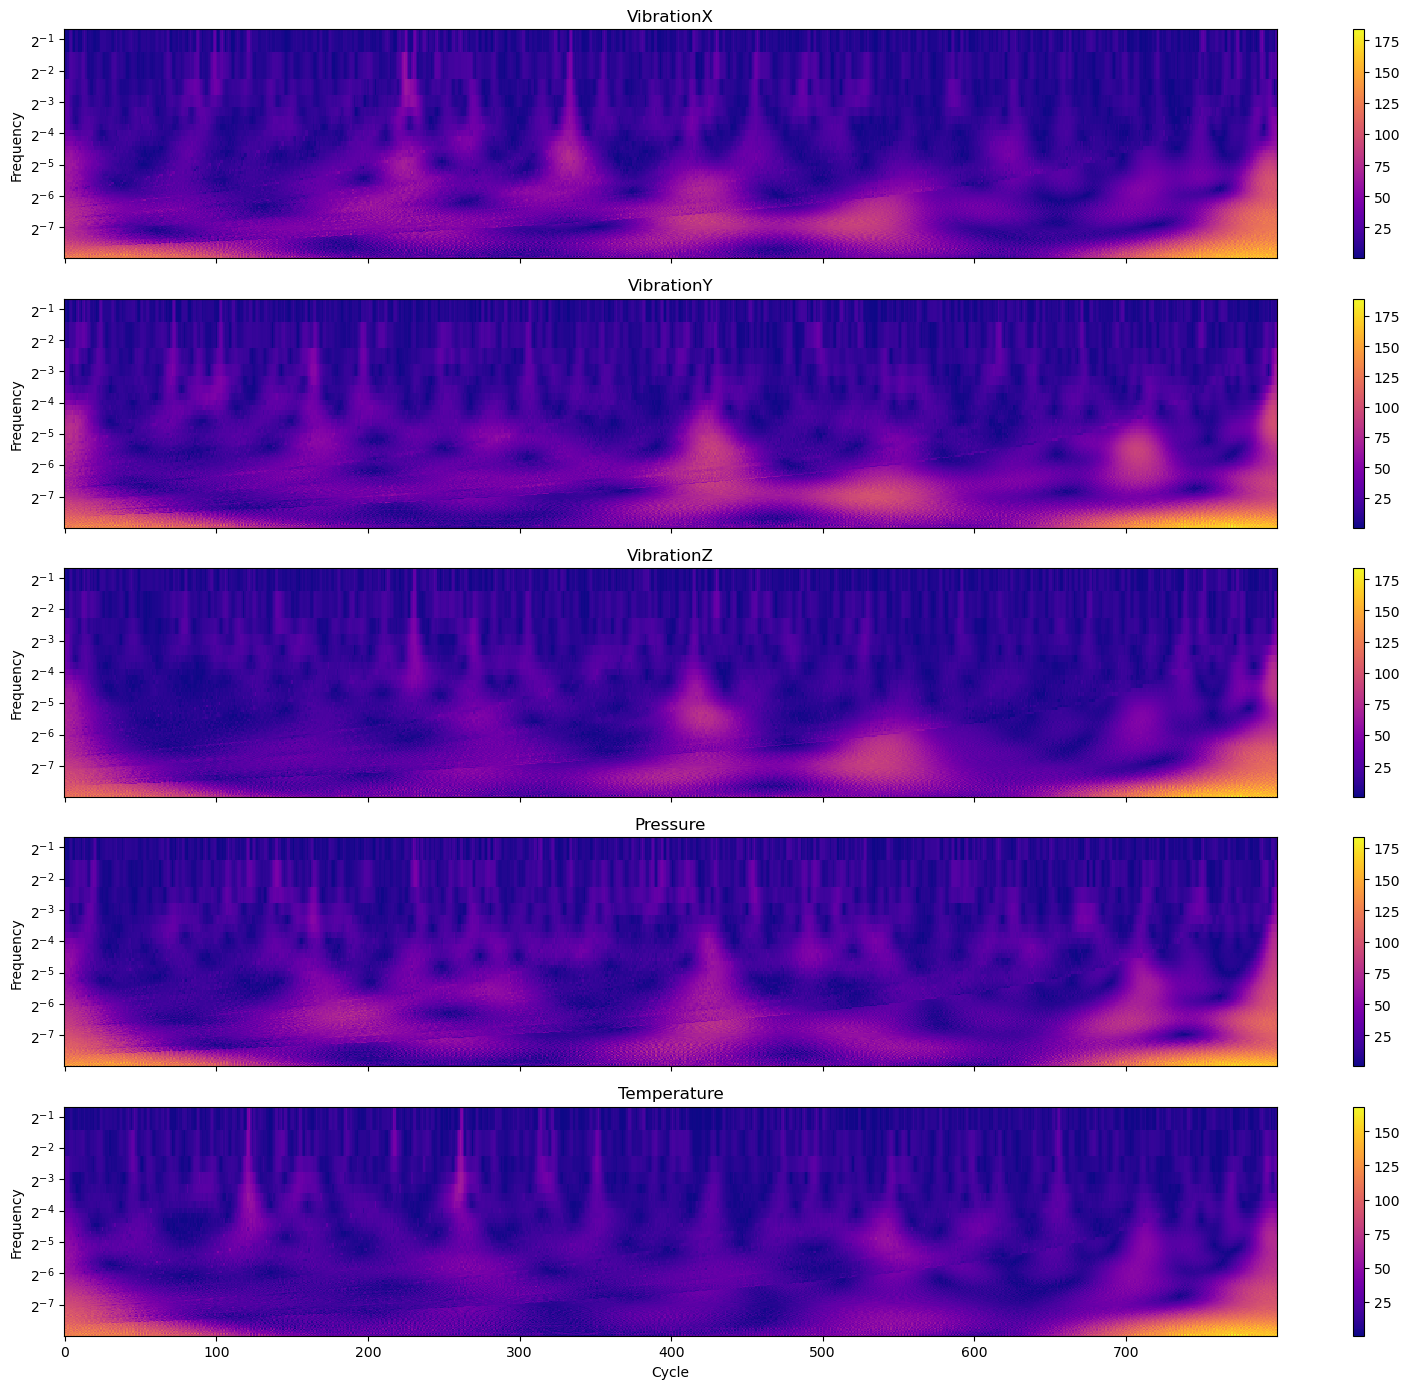

In [32]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

# Selecionar as componentes para análise
vibration_x = data['VibrationX'].values
vibration_y = data['VibrationY'].values
vibration_z = data['VibrationZ'].values
pressure = data['Pressure'].values
temperature = data['Temperature'].values

scales = np.arange(1, 128)

coef_x, freqs_x = pywt.cwt(vibration_x, scales, 'cmor1.5-0.5')
coef_y, freqs_y = pywt.cwt(vibration_y, scales, 'cmor1.5-0.5')
coef_z, freqs_z = pywt.cwt(vibration_z, scales, 'cmor1.5-0.5')
coef_pres, freqs_pres = pywt.cwt(pressure, scales, 'cmor1.5-0.5')
coef_temp, freqs_temp = pywt.cwt(temperature, scales, 'cmor1.5-0.5')

fig, axs = plt.subplots(5, 1, figsize=(16, 14), sharex=True)
cax1 = axs[0].pcolormesh(np.arange(len(vibration_x)), freqs_x, np.abs(coef_x), cmap='plasma')
fig.colorbar(cax1, ax=axs[0])
axs[0].set_title('VibrationX')
axs[0].set_ylabel('Frequency')
axs[0].set_yscale('log', base=2)

cax2 = axs[1].pcolormesh(np.arange(len(vibration_y)), freqs_y, np.abs(coef_y), cmap='plasma')
fig.colorbar(cax2, ax=axs[1])
axs[1].set_title('VibrationY')
axs[1].set_ylabel('Frequency')
axs[1].set_yscale('log', base=2)

cax3 = axs[2].pcolormesh(np.arange(len(vibration_z)), freqs_z, np.abs(coef_z), cmap='plasma')
fig.colorbar(cax3, ax=axs[2])
axs[2].set_title('VibrationZ')
axs[2].set_ylabel('Frequency')
axs[2].set_yscale('log', base=2)

cax4 = axs[3].pcolormesh(np.arange(len(pressure)), freqs_pres, np.abs(coef_pres), cmap='plasma')
fig.colorbar(cax4, ax=axs[3])
axs[3].set_title('Pressure')
axs[3].set_ylabel('Frequency')
axs[3].set_yscale('log', base=2)

cax5 = axs[4].pcolormesh(np.arange(len(temperature)), freqs_temp, np.abs(coef_temp), cmap='plasma')
fig.colorbar(cax5, ax=axs[4])
axs[4].set_title('Temperature')
axs[4].set_ylabel('Frequency')
axs[4].set_yscale('log', base=2)

axs[4].set_xlabel('Cycle')

plt.tight_layout()
plt.savefig('wavelet_Analysis.png', dpi=200, bbox_inches='tight')

In [33]:
pywt.scale2frequency('cmor1.5-0.5',scales)

array([0.5       , 0.25      , 0.16666667, 0.125     , 0.1       ,
       0.08333333, 0.07142857, 0.0625    , 0.05555556, 0.05      ,
       0.04545455, 0.04166667, 0.03846154, 0.03571429, 0.03333333,
       0.03125   , 0.02941176, 0.02777778, 0.02631579, 0.025     ,
       0.02380952, 0.02272727, 0.02173913, 0.02083333, 0.02      ,
       0.01923077, 0.01851852, 0.01785714, 0.01724138, 0.01666667,
       0.01612903, 0.015625  , 0.01515152, 0.01470588, 0.01428571,
       0.01388889, 0.01351351, 0.01315789, 0.01282051, 0.0125    ,
       0.01219512, 0.01190476, 0.01162791, 0.01136364, 0.01111111,
       0.01086957, 0.0106383 , 0.01041667, 0.01020408, 0.01      ,
       0.00980392, 0.00961538, 0.00943396, 0.00925926, 0.00909091,
       0.00892857, 0.00877193, 0.00862069, 0.00847458, 0.00833333,
       0.00819672, 0.00806452, 0.00793651, 0.0078125 , 0.00769231,
       0.00757576, 0.00746269, 0.00735294, 0.00724638, 0.00714286,
       0.00704225, 0.00694444, 0.00684932, 0.00675676, 0.00666